Simply setting up the forward model and the wrapping it within PyTorch

This demo is a jupyter notebook, i.e. intended to be run step by step.

Author: Imraj Singh

First version: 13th of May 2022

CCP SyneRBI Synergistic Image Reconstruction Framework (SIRF).
Copyright 2022 University College London.

This is software developed for the Collaborative Computational Project in Synergistic Reconstruction for Biomedical Imaging (http://www.ccpsynerbi.ac.uk/).

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

# Setting up the forward model

We require a template sinogram, here we use one available in SIRF already. We reduce the dimensionality of the problrm with the zoom_image functionality.

First we import the prerequisite packages.

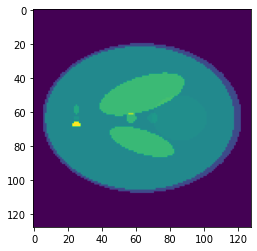

In [1]:
# Import the PET reconstruction engine
import sirf.STIR as pet
# Set the verbosity
pet.set_verbosity(1)
# Store tempory sinograms in RAM
pet.AcquisitionData.set_storage_scheme("memory")
# Import a file that can generate the shepp logan phantom
from odl_funcs.misc import shepp_logan
import sirf
msg = sirf.STIR.MessageRedirector(info=None, warn=None, errr=None)
# Import standard extra packages
import matplotlib.pyplot as plt
import os
import numpy as np
size_xy = 128
x_gt = shepp_logan(space=(1,size_xy,size_xy))
plt.imshow(x_gt[0])

Now we set up the acquisition model based upon the template meta data supplied in 'template_sinogram.hs' and we forward porject the shepp-logan phantom

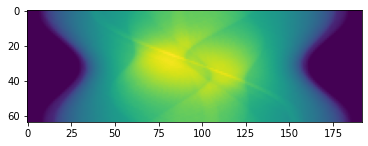

In [2]:
from sirf.Utilities import examples_data_path
sinogram_template = pet.AcquisitionData(examples_data_path('PET')\
                                        + '/thorax_single_slice/template_sinogram.hs');
# create acquisition model
acq_model = pet.AcquisitionModelUsingParallelproj();
image_template = sinogram_template.create_uniform_image(1.0,size_xy);
acq_model.set_up(sinogram_template,image_template);
y_gt = acq_model.forward(image_template.fill(x_gt));
plt.imshow(y_gt.as_array()[0][0])

How does one integrate this into PyTorch? We need to wrap this operator as well as the gradient of the operator. It is worth noting that Torch usually uses the convention (batch,channel/slice,width,height)

In [3]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PT_x_gt = torch.Tensor(x_gt).to(device)

from sirf_torch import primal_op

PT_acq_model = primal_op(image_template, sinogram_template, acq_model)

# Need to unsqueeze to mimic "batch" of size 1
PT_y_gt = PT_acq_model(PT_x_gt.repeat(1,1,1,1))

True
Quadro RTX 4000


# Check the norm between the PT wrapped forward projection and sirf

In [4]:
print(np.linalg.norm(PT_y_gt.detach().cpu().numpy()[0,0,...].ravel()-y_gt.as_array()[0,0,...].ravel()))

0.0
